In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchdiffeq import odeint

from experiments.helpers.training import RunningAverageMeter

# Comparing augmented and unaugmented models
In this notebook we will compare the performance of augmented and unaugmented neural ODEs on a very simple task: learning the function $h(x) = -x$. We will use the same architecture for both models: a single hidden layer with 50 neurons and ReLU activation. 

It makes no sense to try to build a very complex model hoping that the unaugmented model will be able to learn it since it is theoretically impossible: ODE trajectories cannot intersect.

## Unaugmented model
Let's define the model  class. It will be a simple neural network with a single hidden layer with 50 neurons and ReLU activation. The output of the network will be the vector field of the ODE. If $f$ is the neural network, the model is:
$$
\psi(t) = \psi(0) + \int_0^T f(\psi(s)) ds
$$

In [2]:
class UNODE(nn.Module):
    class vector_field(nn.Module):
        def __init__(self, in_out_dim=1, hidden_dim=50, *args, **kwargs):
            super(UNODE.vector_field, self).__init__()

            super().__init__(*args, **kwargs)
            self.net = nn.Sequential(
                # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
                nn.Linear(in_out_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, in_out_dim),
            )

            # Initialize the weights and biases of the network for better convergence
            for m in self.net.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    nn.init.constant_(m.bias, val=0)
                    
        def forward(self, t, y):
            return self.net(y)

    def __init__(self, in_out_dim=1, hidden_dim=50, terminal_time=1.0, method='dopri5'):
        super(UNODE, self).__init__()

        self.net = UNODE.vector_field(in_out_dim, hidden_dim)
        
        self.method = method
        self.T = terminal_time

    # Define the forward pass of the network
    def forward(self, y):
        return odeint(self.net, y, torch.tensor([0.0, self.T]), method=self.method)[1]
    
unode = UNODE()

The loss function will be the same in both cases: the mean squared error between the output of the model and the function $h(x) = -x$.

In [3]:
# Define the loss function
def loss_fn(y_pred, y_true):
    return torch.norm(y_true - y_pred).mean()

### Define the objective function
The objective function is $h(x) = -x$. We will sample points from the interval $[-1, 1]$.

In [4]:
def obj(x):
    return -x

def get_batch(num_samples=100):
        # Sample points from the interval [-1,1]
        x = torch.rand(num_samples, 1) * 2 - 1
        return x

### Training loop

In [5]:
def train(func, optimizer, loss_fn, loss_meter, num_iter=1000):
    for i in range(1000):
        optimizer.zero_grad()
        x = get_batch()
        y_pred = func(x)
        y = obj(x)
        loss = loss_fn(y, y_pred)
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        
        if i % 100 == 0:
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss_meter.avg))

In [6]:
# Train the model
optimizer_unode = optim.Adam(unode.parameters(), lr=0.01)
loss_meter = RunningAverageMeter(0.97)
train(unode, optimizer_unode, loss_fn, loss_meter)

Iter 0000 | Total Loss 11.057549
Iter 0100 | Total Loss 6.224171
Iter 0200 | Total Loss 5.762389
Iter 0300 | Total Loss 5.769634
Iter 0400 | Total Loss 5.771130
Iter 0500 | Total Loss 5.754604
Iter 0600 | Total Loss 5.744836
Iter 0700 | Total Loss 5.761553
Iter 0800 | Total Loss 5.772615
Iter 0900 | Total Loss 5.777551


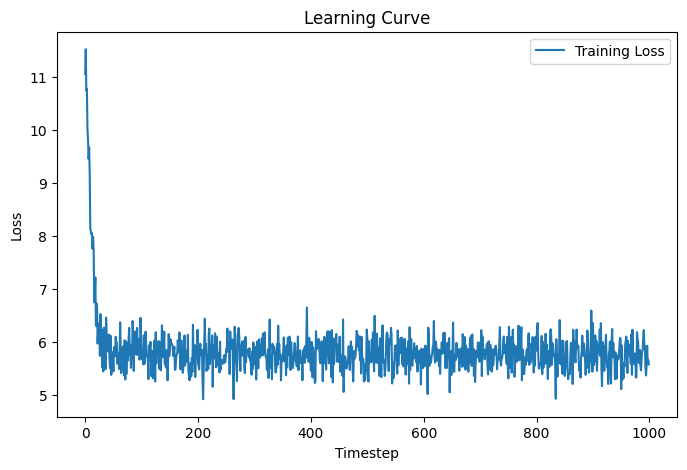

In [7]:
# Plot the learning curve
loss_meter.plot_history()

### Results
As it was expected, the model is unable to learn the objective function. 

In [8]:
# Test the model
x = torch.linspace(-5.0, 5.0, 100).view(-1, 1)
y = unode(x)
loss = loss_fn(y, obj(x))
print('Test loss {:.6f}'.format(loss.item()))

Test loss 29.160513


In [9]:
def plt_function(model):
    # Plot the learnt function for values of x that were not seen during training
    x = torch.linspace(-5.0, 5.0, 100).view(-1, 1)
    y = model(x)
    plt.plot(x.detach().numpy(), y.detach().numpy(), label='$\psi(x)$')
    plt.plot(x.detach().numpy(), obj(x.detach().numpy()), label="$h(x)$")
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('$\psi(x)$')
    plt.show()

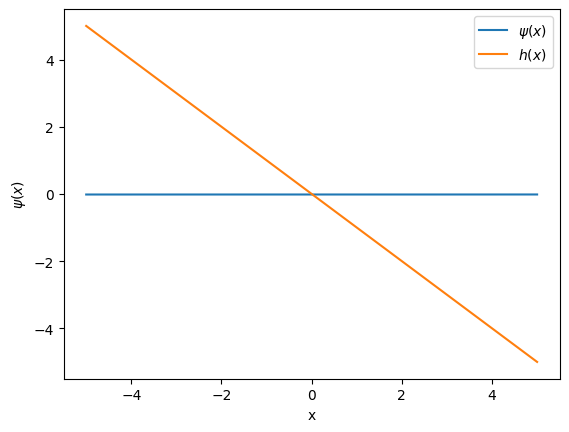

In [10]:
plt_function(unode)

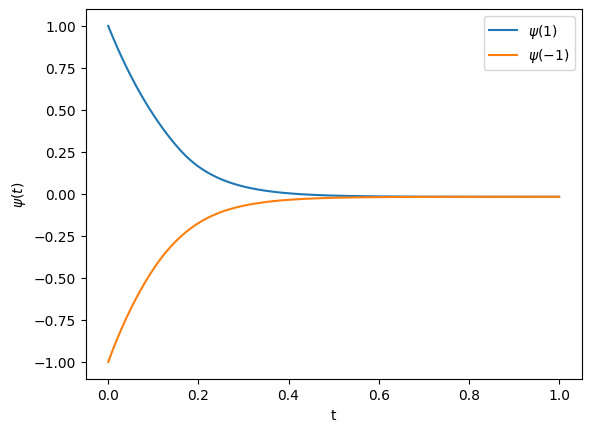

In [11]:
# Plot trajectories for 1 and -1
import numpy as np
t = torch.linspace(0, 1, 100)
x_plus = torch.tensor([1.0])
y_plus = odeint(unode.net, x_plus, t)
x_minus = torch.tensor([-1.0])
y_minus = odeint(unode.net, x_minus, t)
plt.plot(t.detach().numpy(), y_plus.detach().numpy(), label='$\psi(1)$')
plt.plot(t.detach().numpy(), y_minus.detach().numpy(), label="$\psi(-1)$")
plt.legend()
plt.xlabel('t')
plt.ylabel('$\psi(t)$')
plt.show()

## Augmented model
The augmented model is defined as follows:
+ Increase dimenion of the input by adding zeros
+ Apply the unaugmented model with the augmented input
+ Apply a linear transformation to the output to get the desired dimension

In [12]:
class ANODE(nn.Module):
    class vector_field(nn.Module):
        def __init__(self, in_out_dim=2, hidden_dim=50, *args, **kwargs):
            super(ANODE.vector_field, self).__init__()

            super().__init__(*args, **kwargs)
            self.net = nn.Sequential(
                # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
                nn.Linear(in_out_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, in_out_dim),
            )

            # Initialize the weights and biases of the network for better convergence
            for m in self.net.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    nn.init.constant_(m.bias, val=0)
                    
        def forward(self, t, y):
            return self.net(y)
        
    

    def __init__(self, in_dim=2, out_dim=1, hidden_dim=50, terminal_time=1.0, method='dopri5'):
        super(ANODE, self).__init__()

        self.net = ANODE.vector_field(in_dim, hidden_dim)
        
        self.method = method
        self.T = terminal_time
        
        # Augmentation (increase the dimension of the input up to in_out_dim by adding zeros)
        def augment(x):
            return torch.cat([x, torch.zeros(x.shape[0], in_dim - x.shape[1])], 1)
        
        self.augment_fn = augment
        
        self.squash = nn.Linear(in_dim, out_dim)

    # Define the forward pass of the network
    def forward(self, y):
        y = self.augment_fn(y)
        y = odeint(self.net, y, torch.tensor([0.0, self.T]), method=self.method)[1]
        return self.squash(y)
anode = ANODE()

### Training loop

In [13]:
# Train the model
optimizer_anode = optim.Adam(anode.parameters(), lr=0.01)
loss_meter = RunningAverageMeter(0.97)

train(anode, optimizer_anode, loss_fn, loss_meter)

Iter 0000 | Total Loss 8.037078
Iter 0100 | Total Loss 0.876091
Iter 0200 | Total Loss 0.180366
Iter 0300 | Total Loss 0.090325
Iter 0400 | Total Loss 0.127249
Iter 0500 | Total Loss 0.101305
Iter 0600 | Total Loss 0.107615
Iter 0700 | Total Loss 0.113755
Iter 0800 | Total Loss 0.122674
Iter 0900 | Total Loss 0.110499


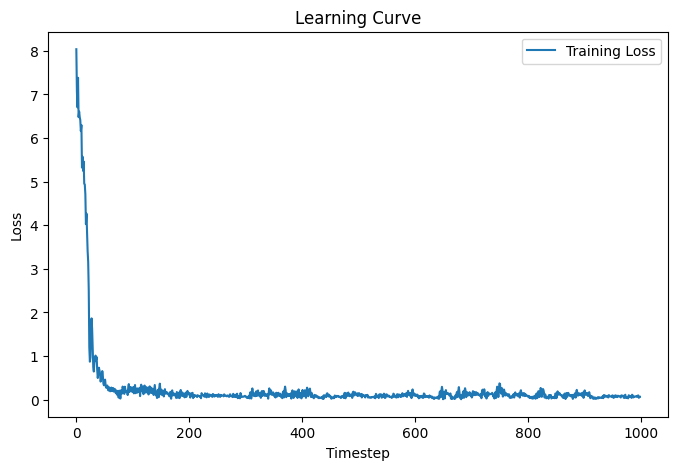

In [14]:
# Plot the learning curve
loss_meter.plot_history()

### Results
The augmented model is able to learn the objective function. Notice how the model outputs values ver close to the objective function for values of $x$ that were not seen during training.

In [15]:
# Test the model
x = torch.linspace(-5.0, 5.0, 100).view(-1, 1)
y = anode(x)
loss = loss_fn(y, obj(x))
print('Test loss {:.6f}'.format(loss.item()))

Test loss 4.022971


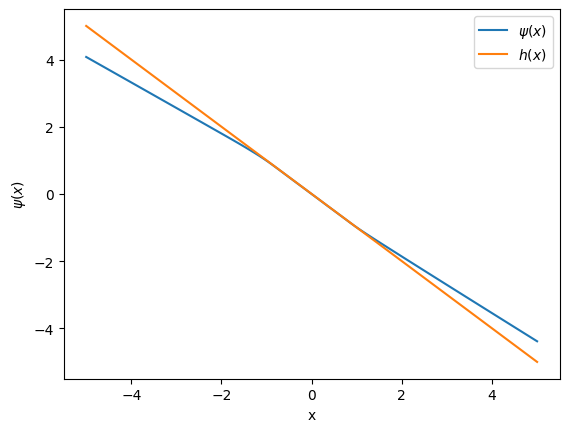

In [16]:
plt_function(anode)